## Tools

|**Tools**|**Deployment Type**|
|---------|-------------------|
| [Google's ML Kit](https://developers.google.com/ml-kit) | On-device (Android and iOS) | 
| [Apple's Core ML](https://developer.apple.com/documentation/coreml?language=objc) and [coremltools Python package](https://apple.github.io/coremltools/docs-guides/source/overview-coremltools.html) | On-device (all Apple devices) | 
| [Amazon Web Service's (AWS) Sagemaker](https://aws.amazon.com/sagemaker/) | Cloud | 
| [Google Cloud's Vertex AI](https://cloud.google.com/vertex-ai) | Cloud | 
| [Microsoft's Azure Machine Learning](https://azure.microsoft.com/en-au/products/machine-learning/) | Cloud | 
| [Hugging Face Spaces](https://huggingface.co/spaces) | Cloud | 
| API with [FastAPI](https://fastapi.tiangolo.com/) | Cloud/self-hosted server | 
| API with [TorchServe](https://pytorch.org/serve/) | Cloud/self-hosted server | 
|[ ONNX (Open Neural Network Exchange)](https://onnx.ai/index.html) |

## 1. Get Data


In [1]:
import torch
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.0.1+cu117
torchvision version: 0.15.2+cu117


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/Assassinsoftomorrow/PyTorch_Course
    !mv PyTorch_Course/going_modular .
    !mv PyTorch_Course/helper_functions.py . # get the helper_functions.py script
    !rm -rf PyTorch_Course
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

C:\Users\Kushagra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

The EffNetB2 model was trained on 20% of the pizza, steak and sushi data from Food101 where as the ViT model was trained on 10%

Since our goal is to deploy the best model for our FoodVision Mini problem, let's start by downloading the 20% pizza, steak and sushi dataset and train an EffNetB2 feature extractor and ViT feature extractor on it and then compare the two models.

We can download the data using the `download_data()` function we created in 07. PyTorch Experiment Tracking section 1 from `helper_functions.py`.

In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi_20_percent')

In [5]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 2. FoodVision Mini model deployment experiment outline
The ideal deployed model FoodVision Mini performs well and fast.

We'd like our model to perform as close to real-time as possible.

Real-time in this case being ~30FPS (frames per second) because that's about[ how fast the human eye can see](https://www.healthline.com/health/human-eye-fps)

For classifying three different classes (pizza, steak and sushi), we'd like a model that performs at 95%+ accuracy

**Goals:**
- **Performance** - A model that performs at 95%+ accuracy.
- **Speed** - A model that can classify an image at ~30FPS (0.03 seconds inference time per image, also known as latency).

Comparing the best performing models:
1. **EffNetB2 feature extractor** (EffNetB2 for short) - originally created in 07. PyTorch Experiment Tracking using `torchvision.models.efficientnet_b2()` with adjusted classifier layers.
2. **ViT-B/16 feature extractor** (ViT for short) - originally created in 08. PyTorch Paper Replicating using `torchvision.models.vit_b_16()` with adjusted head layers.
    > Note ViT-B/16 stands for "Vision Transformer Base, patch size 16".


## 3. Creating an EffNetB2 feature extractor

In [6]:
# Setup pretrained weights
effnetb2_weights= torchvision.models.EfficientNet_B2_Weights.DEFAULT # best weights

# Get Effnet b2 transformer
effnetb2_transforms= effnetb2_weights.transforms()

# Seup pretrained model
effnetb2= torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# Freeze the baselayers in the model
for parameter in effnetb2.parameters():
    parameter.requires_grad= False

Checking out the classifier layer since that is the only layer we will change

In [7]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
effnetb2.classifier= nn.Sequential(
    nn.Dropout(p=0.3, inplace= True),
    nn.Linear(in_features=1408, out_features=3) # changing the output features to since we only have 3 classes
)

Getting a summary of the model

In [9]:
from torchinfo import summary

summary(model=effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.1 Creating a function to make an EffNetB2 feature extractor


In [10]:
def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

In [11]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3, seed=42)

In [12]:
# from torchinfo import summary

# # Print EffNetB2 model summary (uncomment for full output) 
# summary(effnetb2, 
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

### 3.2 Creating DataLoaders for EffNetB2

In [13]:
from going_modular.data_setup import create_dataloaders
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names= create_dataloaders(train_dir=train_dir,
                                                                                     test_dir=test_dir,
                                                                                     transform=effnetb2_transforms,
                                                                                     batch_size=32)

### 3.3 Training EffNetB2 

In [14]:
from going_modular.engine import train

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = train(model=effnetb2,
                         train_dataloader=train_dataloader_effnetb2,
                         test_dataloader=test_dataloader_effnetb2,
                         epochs=10,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         device=device)

 10%|█         | 1/10 [00:14<02:11, 14.62s/it]

Epoch: 1 | train_loss: 0.9791 | train_acc: 0.5729 | test_loss: 0.7367 | test_acc: 0.9284


 20%|██        | 2/10 [00:28<01:52, 14.02s/it]

Epoch: 2 | train_loss: 0.7109 | train_acc: 0.8583 | test_loss: 0.5853 | test_acc: 0.9472


 30%|███       | 3/10 [00:41<01:37, 13.87s/it]

Epoch: 3 | train_loss: 0.5903 | train_acc: 0.8896 | test_loss: 0.4856 | test_acc: 0.9500


 40%|████      | 4/10 [00:56<01:26, 14.34s/it]

Epoch: 4 | train_loss: 0.4504 | train_acc: 0.9042 | test_loss: 0.4317 | test_acc: 0.9409


 50%|█████     | 5/10 [01:13<01:14, 14.96s/it]

Epoch: 5 | train_loss: 0.4316 | train_acc: 0.8958 | test_loss: 0.3888 | test_acc: 0.9290


 60%|██████    | 6/10 [01:27<00:58, 14.67s/it]

Epoch: 6 | train_loss: 0.4412 | train_acc: 0.8792 | test_loss: 0.3478 | test_acc: 0.9688


 70%|███████   | 7/10 [01:43<00:45, 15.12s/it]

Epoch: 7 | train_loss: 0.4319 | train_acc: 0.8771 | test_loss: 0.3224 | test_acc: 0.9625


 80%|████████  | 8/10 [01:57<00:30, 15.00s/it]

Epoch: 8 | train_loss: 0.3903 | train_acc: 0.8979 | test_loss: 0.3423 | test_acc: 0.9290


 90%|█████████ | 9/10 [02:13<00:15, 15.16s/it]

Epoch: 9 | train_loss: 0.3747 | train_acc: 0.8938 | test_loss: 0.3101 | test_acc: 0.9256


100%|██████████| 10/10 [02:29<00:00, 14.94s/it]

Epoch: 10 | train_loss: 0.3657 | train_acc: 0.8667 | test_loss: 0.2781 | test_acc: 0.9625


### 3.4 Inspecting EffNetB2 loss curves

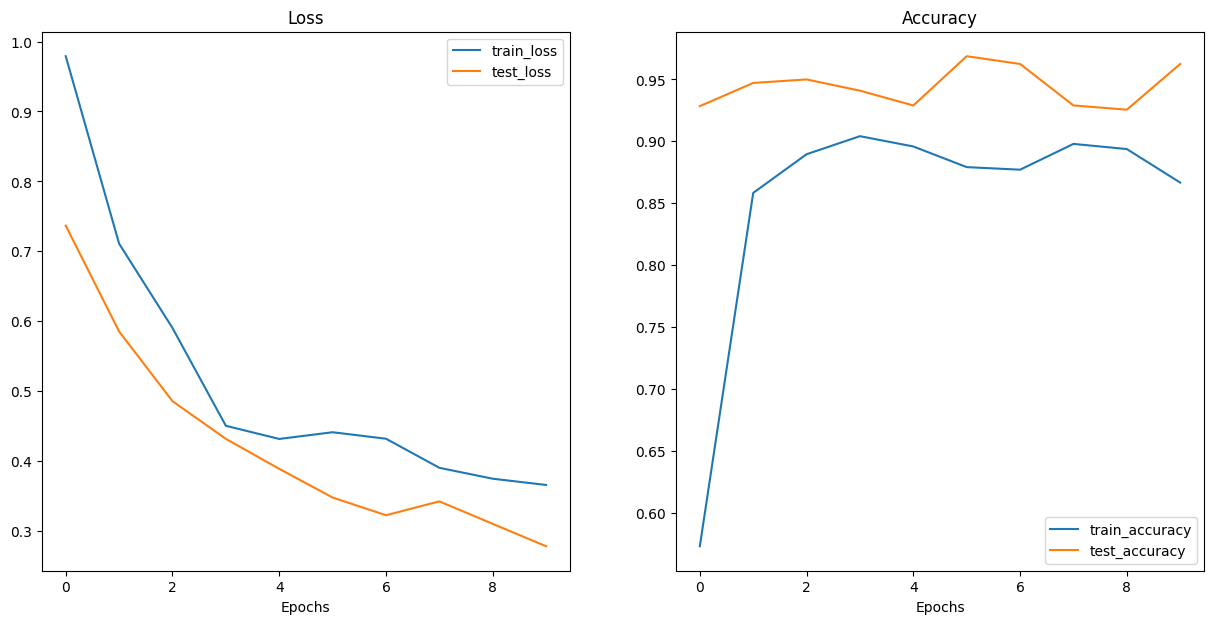

In [15]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor

In [16]:
from going_modular.utils import save_model

# Save the model
save_model(model=effnetb2,
           target_dir="models",
           model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Checking the size of EffNetB2 feature extractor

Since one of our criteria for deploying a model to power FoodVision Mini is speed (~30FPS or better), let's check the size of our model.

Not always the case, the size of a model can influence its inference speed.

To check our model's size in bytes, we can use Python's `pathlib.Path.stat("path_to_model").st_size` and then we can convert it (roughly) to megabytes by dividing it by <i>(1024*1024)</i>.

In [17]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


### 3.7 Collecting EffNetB2 feature extractor stats
We've got a few statistics about our EffNetB2 feature extractor model such as test loss, test accuracy and model size, how about we collect them all in a dictionary so we can compare them to the upcoming ViT feature extractor.

We can do so by counting the number of elements (or patterns/weights) in `effnetb2.parameters()`. We'll access the number of elements in each parameter using the `torch.numel()` (short for "number of elements") method.

In [18]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [19]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.27809305787086486,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## 4. Creating a ViT feature extractor

In [20]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [21]:
def create_vit_model(num_classes:int=3, 
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model. 
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes
    
    return model, transforms

In [22]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3, seed=42)

In [23]:
from torchinfo import summary

# Print ViT feature extractor model summary (uncomment for full output)
summary(vit, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Create DataLoaders for ViT

In [24]:
# Setup ViT DataLoaders
train_dataloader_vit, test_dataloader_vit, class_names = create_dataloaders(train_dir=train_dir,
                                                                            test_dir=test_dir,
                                                                            transform=vit_transforms,
                                                                            batch_size=32)

### 4.2 Training ViT feature extractor

In [25]:
# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = train(model=vit,
                    train_dataloader=train_dataloader_vit,
                    test_dataloader=test_dataloader_vit,
                    epochs=10,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    device=device)

 10%|█         | 1/10 [00:29<04:22, 29.21s/it]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381


 20%|██        | 2/10 [00:58<03:54, 29.31s/it]

Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602


 30%|███       | 3/10 [01:28<03:25, 29.43s/it]

Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693


 40%|████      | 4/10 [01:56<02:53, 28.88s/it]

Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722


 50%|█████     | 5/10 [02:24<02:22, 28.58s/it]

Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784


 60%|██████    | 6/10 [02:52<01:53, 28.44s/it]

Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722


 70%|███████   | 7/10 [03:20<01:24, 28.24s/it]

Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784


 80%|████████  | 8/10 [03:47<00:56, 28.04s/it]

Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722


 90%|█████████ | 9/10 [04:15<00:27, 27.90s/it]

Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784


100%|██████████| 10/10 [04:45<00:00, 28.52s/it]

Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### 4.3 Inspecting ViT loss curves

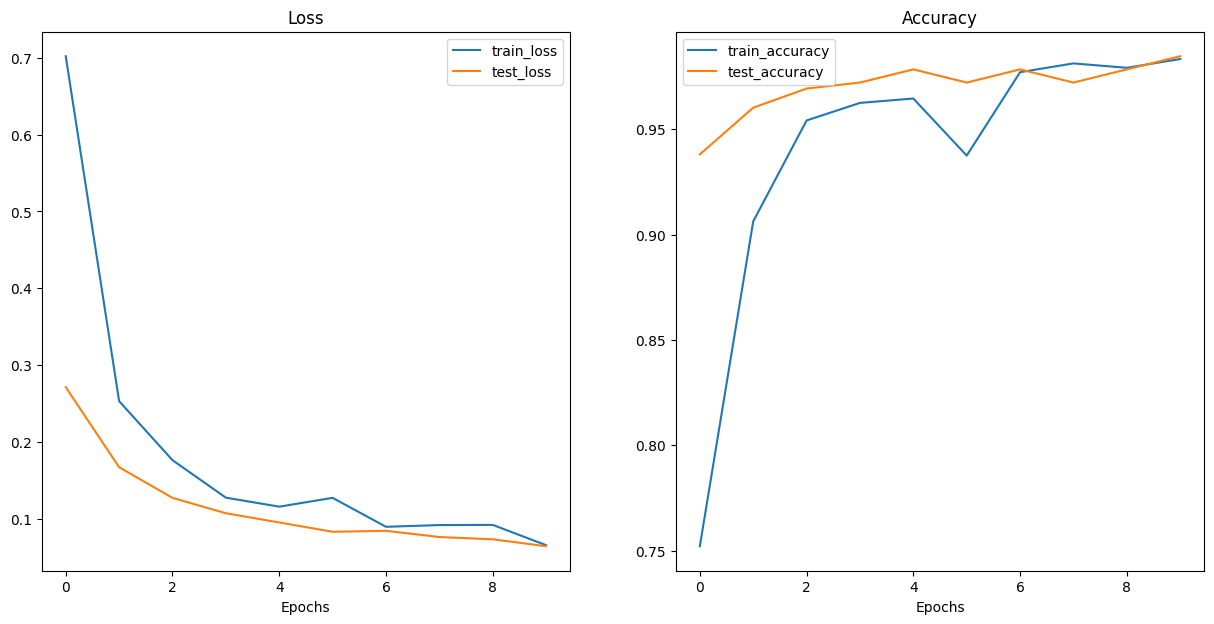

In [26]:
# Plotting loss curves
plot_loss_curves(vit_results)

### 4.4 Saving ViT feature extractor

In [27]:
# Save the model
save_model(model=vit,
           target_dir="models",
           model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5 Checking the size of ViT feature extractor

In [28]:
# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


### 4.6 Collecting ViT feature extractor stats

In [29]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [30]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06443450981751084,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## 5. Making predictions with our trained models and timing them
Goal:
1. Performs well (over 95% test accuracy)
2. Fast (30+ FPS)

Test Criteria:
1. Loop through test images
2. Time how long each model takes to make a prediction on the image

In [31]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data\pizza_steak_sushi_20_percent\test


[WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg')]

### 5.1 Creating a function to make predictions across the test dataset
Now we've got a list of our test image paths, let's get to work on our `pred_and_store()` function:

1. Create a function that takes a list of paths, a trained PyTorch model, a series of transforms (to prepare images), a list of target class names and a target device.
2. Create an empty list to store prediction dictionaries (we want the function to return a list of dictionaries, one for each prediction).
3. Loop through the target input paths (steps 4-14 will happen inside the loop).
4. Create an empty dictionary for each iteration in the loop to store prediction values per sample.
5. Get the sample path and ground truth class name (we can do this by infering the class from the path).
6. Start the prediction timer using Python's `timeit.default_timer()`.
7. Open the image using `PIL.Image.open(path)`.
8. Transform the image so it's capable of being used with the target model as well as add a batch dimension and send the image to the target device.
9. Prepare the model for inference by sending it to the target device and turning on `eval()` mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and calculate the prediction probability using `torch.softmax()` and the target label using `torch.argmax()`.
11. Add the prediction probability and prediction class to the prediction dictionary created in step 4. Also make sure the prediction probability is on the CPU so it can be used with non-GPU libraries such as NumPy and pandas for later inspection.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary created in step 4.
13. See if the predicted class matches the ground truth class from step 5 and add the result to the prediction dictionary created in step 4.
14. Append the updated prediction dictionary to the empty list of predictions created in step 2.
15. Return the list of prediction dictionaries.

In [32]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path], 
                   model: torch.nn.Module,
                   transform: torchvision.transforms, 
                   class_names: List[str], 
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    
    # 2. Create an empty list to store prediction dictionaires
    pred_list = []
    
    # 3. Loop through target paths
    for path in tqdm(paths):
        
        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        # 6. Start the prediction timer
        start_time = timer()
        
        # 7. Open image path
        img = Image.open(path)
        
        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device) 
        
        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()
        
        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample 
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on) 
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)
    
    # 15. Return list of prediction dictionaries
    return pred_list

### 5.2 Making and timing predictions with EffNetB2
1. Device- we're going to hardcoed our predictions to happen on GPU (because we won't always be sure of having a GPU when we deplooy the model)
2. Transforms- we want to make sure each of the models are predicting on images that have been prepared with the appropriate transforms

In [33]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts= pred_and_store(paths= test_data_paths,
                                          model= effnetb2,
                                          transform= effnetb2_transforms,
                                          class_names= class_names,
                                          device='cpu')


100%|██████████| 150/150 [00:12<00:00, 11.79it/s]


In [34]:
effnetb2_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9943,
  'pred_class': 'pizza',
  'time_for_pred': 0.1557,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.4779,
  'pred_class': 'pizza',
  'time_for_pred': 0.0963,
  'correct': True}]

In [35]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9943,pizza,0.1557,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.4779,pizza,0.0963,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9911,pizza,0.0903,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.6986,pizza,0.1159,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.7563,pizza,0.0935,True


In [36]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

correct
True     144
False      6
Name: count, dtype: int64

In [37]:
# Find the average time per prediction 
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.0844 seconds


In [38]:
# Add EffNetB2 average prediction time to stats dictionary 
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.27809305787086486,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.0844}

### 5.3 Making and timing predictions with ViT

In [39]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

100%|██████████| 150/150 [00:30<00:00,  4.98it/s]


In [40]:
# Check the first couple of ViT predictions on the test dataset
vit_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9987,
  'pred_class': 'pizza',
  'time_for_pred': 0.4534,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9957,
  'pred_class': 'pizza',
  'time_for_pred': 0.1712,
  'correct': True}]

In [41]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9987,pizza,0.4534,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9957,pizza,0.1712,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9987,pizza,0.2049,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9869,pizza,0.2107,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9698,pizza,0.1945,True


In [42]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [43]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.1998 seconds


In [44]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443450981751084,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.1998}

## 6. Comparing model results, prediction times and size

In [45]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.278093,96.25,7705221,29,0.0844,EffNetB2
1,0.064435,98.47,85800963,327,0.1998,ViT


In [46]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T


,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.231701,1.023065,11.135432,11.275862,2.367299


* 11x+ the number of parameters.
* 11x+ the model size.
* 2.2x+ the prediction time per image.

### 6.1 Visualizing the speed vs. performance tradeoff
1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT `time_per_pred_cpu` and `test_acc values`.
2. Add titles and labels respective of the data and customize the fontsize for aesthetics.
3. Annotate the samples on the scatter plot from step 1 with their appropriate labels (the model names).
4. Create a legend based on the model sizes (`model_size (MB)`).

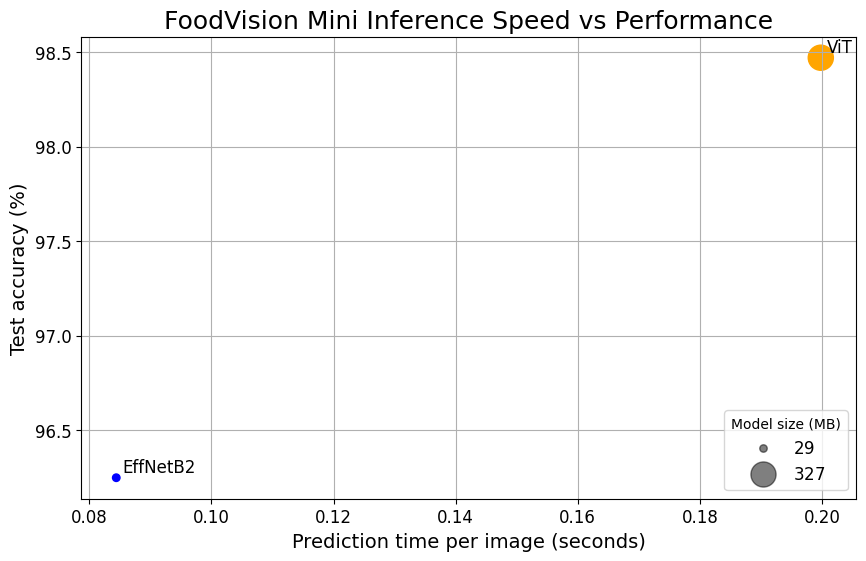

In [47]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(data=df, 
                     x="time_per_pred_cpu", 
                     y="test_acc", 
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270 
                xy=(row["time_per_pred_cpu"]+0.001, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, 
                              labels, 
                              loc="lower right", 
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

## 7. Bringing FoodVision Mini to life by creating a Gradio demo
The EffNetB2 model is not as good as we expected it to be, but it is comparitively way better than the ViT model. Therefore, we will deploy the EffNetB2 model.

There are several ways to deploy a macchine learning model, each with a specofoc use case. We're going to focus on the quickest way to get a model deployed on the internet. [Gradio](https://www.gradio.app/)


### 7.1 Gradio overview
The overall premise of Gradio is very similar to what we've been repeating throughout the course.

What are our **inputs** and **outputs**?

Our machine learning model does.

inputs -> ML model -> outputs

images of food -> EffNetB2 -> outputs

Gradio emulates this paradigm by creating an interface (`gradio.Interface()`) from inputs to outputs.
```python
gradio.Interface(fn, inputs, outputs)
```
`fn` is a Python function to map the `inputs` to the `outputs`.

*Gradio provides a very helpful `Interface` class to easily create an inputs -> model/function -> outputs workflow where the inputs and outputs could be almost anything you want. For example, you might input Tweets (text) to see if they're about machine learning or not or [input a text prompt to generate images](https://huggingface.co/blog/stable_diffusion).*

In [48]:
# Import/install Gradio 
try:
    import gradio as gr
except: 
    !pip -q install gradio
    import gradio as gr
    
print(f"Gradio version: {gr.__version__}")

Gradio version: 3.48.0


### 7.2 Creating a function to map our inputs and outputs
To create our FoodVision Mini demo with Gradio, we'll need a function to map our inputs to our outputs.

We created a function earlier called `pred_and_store()` to make predictions with a given model across a list of target files and store them in a list of dictionaries.

How about we create a similar function but this time focusing on a making a prediction on a single image with our EffNetB2 model?

More specifically, we want a function that takes an image as input, preprocesses (transforms) it, makes a prediction with EffNetB2 and then returns the prediction (pred or pred label for short) as well as the prediction probability (pred prob).

And while we're here, let's return the time it took to do so too:
```python
input: image -> transform -> predict with EffNetB2 -> output: pred, pred prob, time taken
```
This will be our `fn` parameter for our Gradio interface.

First, let's make sure our EffNetB2 model is on the CPU (since we're sticking with CPU-only predictions, however you could change this if you have access to a GPU).

In [49]:
# Put EffNetB2 on CPU
effnetb2.to("cpu") 

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [50]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 7.3 Creating a list of example images
Our `predict()` function enables us to go from inputs -> transform -> ML model -> outputs.

Which is exactly what we need for our Graido demo.

But before we create the demo, let's create one more thing: a list of examples.

Gradio's `Interface` class takes a list of examples of as an optional parameter (`gradio.Interface(examples=List[Any])`).

And the format for the `examples` parameter is a list of lists.

So let's create a list of lists containing random filepaths to our test images.

In [51]:
# Create a list of example inputs to our Gradio demo
import random

example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data\\pizza_steak_sushi_20_percent\\test\\pizza\\482858.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\steak\\3063435.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\pizza\\476421.jpg']]

### 7.4 Building a Gradio interface
Let's create a Gradio interface to replicate the workflow:
```python
input: image -> transform -> predict with EffNetB2 -> output: pred, pred prob, time taken
```
We can do with the gradio.Interface() class with the following parameters:

* `fn` - a Python function to map `inputs` to `outputs`, in our case, we'll use our `predict()` function.
* `inputs` - the input to our interface, such as an image using `gradio.Image()` or `"image"`.
* `outputs` - the output of our interface once the `inputs` have gone through the fn, such as a label using `gradio.Label()` (for our model's predicted labels) or number using `gradio.Number()` (for our model's prediction time).
    > **Note**: Gradio comes with many in-built `inputs` and `outputs` options known as "[Components](https://www.gradio.app/docs/interface)".
* `examples` - a list of examples to showcase for the demo.
* `title` - a string title of the demo.
* `description` - a string description of the demo.
* `article` - a reference note at the bottom of the demo.
Once we've created our demo instance of `gr.Interface()`, we can bring it to life using `gradio.Interface().launch()` or `demo.launch()` command.

In [52]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://1c6c04900ecb35204f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


If you set the parameter `share=True` in the `launch()` method, Gradio also provides you with a shareable link such as `https://123XYZ.gradio.app` (this link is an example only and likely expired) which is valid for 72-hours.

## 8. Turning our FoodVision Mini Gradio Demo into a deployable app
Tp make our FoodVision Mini demo more permanent, we can package it into an app and upload it to [Hugging Face Spaces](https://huggingface.co/spaces/launch).

### 8.1 Deployed Gradio app structure
To upload our demo Gradio app, we'll want to put everything relating to it into a single directory.

For example, our demo might live at the path `demos/foodvision_mini/` with the file structure:

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```
Where:
* `09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth` is our trained PyTorch model file.
* `app.py` contains our Gradio app (similar to the code that launched the app).
    > **Note:** `app.py` is the default filename used for Hugging Face Spaces, if you deploy your app there, Spaces will by default look for a file called `app.py` to run. This is changable in settings.
* `examples/` contains example images to use with our Gradio app.
* `model.py` contains the model defintion as well as any transforms assosciated with the model.
* `requirements.txt` contains the dependencies to run our app such as torch, torchvision and gradio.

### 8.2 Creating a `demos` folder to store our FoodVision Mini app files
To begin, let's first create a `demos/` directory to store all of our FoodVision Mini app files.

We can do with Python's `pathlib.Path("path_to_dir")` to establish the directory path and `pathlib.Path("path_to_dir").mkdir()` to create it.

In [53]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path= Path('demos/food_vision_mini')

# Remove files that might already exist there and create new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True, # make the parent folders?
                                    exist_ok=True) # create it even if it already exists?
else:
    # If the file doesn't exist, create it anyway
    foodvision_mini_demo_path.mkdir(parents=True, 
                                    exist_ok=True)

### 8.3 Creating a folder of example images to use with our FoodVision Mini demo
To store our FoodVision Mini demo files, let's add some examples to it.

Three example images from the test dataset should be enough.

To do so we'll:

1. Create an `examples/` directory within the `demos/foodvision_mini` directory.
2. Choose three random images from the test dataset and collect their filepaths in a list.
3. Copy the three random images from the test dataset to the `demos/foodvision_mini/examples/` directory.

In [54]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data\pizza_steak_sushi_20_percent\test\sushi\592799.jpg to demos\food_vision_mini\examples\592799.jpg
[INFO] Copying data\pizza_steak_sushi_20_percent\test\steak\3622237.jpg to demos\food_vision_mini\examples\3622237.jpg
[INFO] Copying data\pizza_steak_sushi_20_percent\test\pizza\2582289.jpg to demos\food_vision_mini\examples\2582289.jpg


Now to verify our examples are present, let's list the contents of our `demos/foodvision_mini/examples/` directory with `os.listdir()`and then format the filepaths into a list of lists (so it's compatible with Gradio's `gradio.Interface()` `example` parameter).

In [55]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/2582289.jpg'], ['examples/3622237.jpg'], ['examples/592799.jpg']]

### 8.4 Moving our trained EffNetB2 model to our FoodVision Mini demo directory
We previously saved our FoodVision Mini EffNetB2 feature extractor model under `models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth`.

And rather double up on saved model files, let's move our model to our `demos/foodvision_mini` directory.

We can do so using Python's `shutil.move()` method and passing in `src` (the source path of the target file) and `dst` (the destination path of the target file to be moved to) parameters.

In [56]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model 
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")
    
    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path, 
                dst=effnetb2_foodvision_mini_model_destination)
    
    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos\food_vision_mini\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


### 8.5 Turning our EffNetB2 model into a Python script (`model.py`)
Our current model's state_dict is saved to `demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent`.pth.

To load it in we can use `model.load_state_dict()` along with `torch.load()`.

But before we can do this, we first need a way to instantiate a model.

To do this in a modular fashion we'll create a script called `model.py` which contains our `create_effnetb2_model()` function we created in section 3.1: Creating a function to make an EffNetB2 feature extractor.

That way we can import the function in another script (see `app.py` below) and then use it to create our EffNetB2 `model` instance as well as get its appropriate transforms.

Just like in 05. PyTorch Going Modular, we'll use the `%%writefile path/to/file` magic command to turn a cell of code into a file.


In [57]:
%%writefile demos/food_vision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Writing demos/food_vision_mini/model.py


### 8.6 Turning our FoodVision Mini Gradio app into a Python script (`app.py`)
We've now got a `model.py` script as well as a path to a saved model `state_dict` that we can load in.

Time to construct `app.py`.

We call it `app.py` because by default when you create a HuggingFace Space, it looks for a file called `app.py` to run and host (though you can change this in settings).

The `app.py` script will put together all of the pieces of the puzzle to create our Gradio demo and will have four main parts:

1. **Imports and class names setup** - Here we'll import the various dependencies for our demo including the `create_effnetb2_model()` function from` model.py` as well as setup the different class names for our FoodVision Mini app.
2. **Model and transforms preparation** - Here we'll create an EffNetB2 model instance along with the transforms to go with it and then we'll load in the saved model `weights/state_dict`. When we load the model we'll also set `map_location=torch.device("cpu")` in `torch.load()` so our model gets loaded onto the CPU regardless of the device it trained on (we do this because we won't necessarily have a GPU when we deploy and we'll get an error if our model is trained on GPU but we try to deploy it to CPU without explicitly saying so).
3. `Predict function` - Gradio's `gradio.Interface()` takes a `fn` parameter to map inputs to outputs, our `predict()` function will be the same as the one we defined above in section 7.2: Creating a function to map our inputs and outputs, it will take in an image and then use the loaded transforms to preprocess it before using the loaded model to make a prediction on it.
    >**Note**: We'll have to create the example list on the fly via the `examples` parameter. We can do so by creating a list of the files inside the `examples/` directory with: `[["examples/" + example] for example in os.listdir("examples")]`.
4. **Gradio app** - This is where the main logic of our demo will live, we'll create a `gradio.Interface()` instance called demo to put together our inputs,` predict()` function and outputs. And we'll finish the script by calling `demo.launch()` to launch our FoodVision Mini demo!

In [58]:
%%writefile demos/food_vision_mini/app.py
### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/food_vision_mini/app.py


### 8.7 Creating a requirements file for FoodVision Mini (`requirements.txt`)
The last file we need to create for our FoodVision Mini app is a `requirements.txt` file.

This will be a text file containing all of the required dependencies for our demo.

When we deploy our demo app to Hugging Face Spaces, it will search through this file and install the dependencies we define so our app can run.
1. `torch==2.0.1+cu117`
2. `torchvision==0.15.2+cu117`
3. `gradio==3.48.0`

In [59]:
%%writefile demos/food_vision_mini/requirements.txt
torch==2.0.1+cu117
torchvision==0.15.2+cu117
gradio==3.48.0

Writing demos/food_vision_mini/requirements.txt


## 9. Deploying our FoodVision Mini app to HuggingFace Spaces
There are two main options for uploading to a Hugging Face Space (also called a [Hugging Face Repository](https://huggingface.co/docs/hub/repositories-getting-started#getting-started-with-repositories), similar to a git repository):

1. [Uploading via the Hugging Face Web interface (easiest)](https://huggingface.co/docs/hub/repositories-getting-started#adding-files-to-a-repository-web-ui).
2. [Uploading via the command line or terminal](https://huggingface.co/docs/hub/repositories-getting-started#terminal).
    >**Bonus**: You can also use the [`huggingface_hub` library](https://huggingface.co/docs/huggingface_hub/index) to interact with Hugging Face, this would be a good extension to the above two options.

In [60]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
# IFrame(src="https://huggingface.co/spaces/kushagra-909/FoodVision_mini", width=900, height=750)

## 10. Creating FoodVision Big
Since FoodVision Mini is trained on pizza, steak and sushi images from the Food101 dataset (101 classes of food x 1000 images each), how about we make FoodVision Big by training a model on all 101 classes!

We'll go from three classes to 101!

### 10.1 Creating a model and transforms for FoodVision Big

In [61]:
# Create EffNetB2 model capable of fitting to 101 classes for Food101
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [62]:
from torchinfo import summary

# Get a summary of EffNetB2 feature extractor for Food101 with 101 output classes (uncomment for full output)
summary(effnetb2_food101, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [63]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms= torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])

In [64]:
print(f"Training transforms:\n{food101_train_transforms}\n") 
print(f"Testing transforms:\n{effnetb2_transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


### 10.2 Getting data for FoodVision Big
To get the whole Food101 dataset, we can use `torchvision.datasets.Food101()`.

We'll first setup a path to directory `data/` to store the images.

Then we'll download and transform the training and testing dataset splits using `food101_train_transforms` and `effnetb2_transforms` to transform each dataset respectively.

In [65]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=food101_train_transforms, # perform data augmentation on training data
                              download=True) # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms, # perform normal EffNetB2 transforms on test data
                             download=True)

In [66]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 10.3 Creating a subset of the Food101 dataset for faster experimenting
To keep training fast, let's create a 20% split of the training and test datasets.

Our goal will be to see if we can beat the original Food101 paper's best results with only 20% of the data.

To breakdown the datasets we've used/will use:
| **Notebook(s)** | **Project name** | **Dataset** | **Number of classes** | **Training images** | **Testing images** |
|-----------------|------------------|-------------|-----------------------|---------------------|--------------------|
| 04, 05, 06, 07, 08    |   FoodVision Mini (10% data)  |	Food101 custom split |  3 (pizza, steak, sushi)   | 225   | 75    |
| 07, 08, 09            |   FoodVision Mini (20% data)  |	Food101 custom split |  3 (pizza, steak, sushi)   | 450   |	150   |
| 09 (this one)         |   FoodVision Big (20% data)   |	Food101 custom split |  101 (all Food101 classes) |	15150 |	5050  |
| Extension             |   FoodVision Big              |   Food101 all data     |  101                       | 75750 | 25250 |

To make our `FoodVision Big (20% data)` split, let's create a function called `split_dataset()` to split a given dataset into certain proportions.

We can use `torch.utils.data.random_split()` to create splits of given sizes using the lengths parameter.

The lengths parameter accepts a list of desired split lengths where the total of the list must equal the overall length of the dataset.

For example, with a dataset of size 100, you could pass in `lengths=[20, 80]` to receive a 20% and 80% split.

We'll want our function to return two splits, one with the target length (e.g. 20% of the training data) and the other with the remaining length (e.g. the remaining 80% of the training data).

Finally, we'll set `generator` parameter to a `torch.manual_seed()` value for reproducibility.

In [67]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split? 
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and 
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = len(dataset) - length_1 # remaining length
        
    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")
    
    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset, 
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
    return random_split_1, random_split_2

In [68]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

### 10.4 Turning our Food101 datasets into DataLoaders
Converting Food101 20% dataset splits into `DataLoader`'s using `torch.utils.data.DataLoader()`.

We'll set `shuffle=True` for the training data only and the batch size to `32` for both datasets.

And we'll set `num_workers` to `os.cpu_count()`.

In [71]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <=4 else 4 # According to online forums, num_workers= 4*num_gpu_count is a good assignment. 

# Create Food101 20 percent training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)
# Create Food101 20 percent testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

### 10.5 Training FoodVision Big model
We'll create an optimizer using `torch.optim.Adam()` and a learning rate of `1e-3`.

And because we've got so many classes, we'll also setup a loss function using `torch.nn.CrossEntropyLoss()` with `label_smoothing=0.1`, inline with [`torchvision`'s state-of-the-art training](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#label-smoothing).

[**What's label smoothening?**](https://paperswithcode.com/method/label-smoothing)
Label smoothing is a regularization technique (regularization is another word to describe the process of preventing overfitting) that reduces the value a model gives to anyone label and spreads it across the other labels.

In essence, rather than a model getting too confident on a single label, label smoothing gives a non-zero value to other labels to help aid in generalization.

For example, if a model without label smoothing had the following outputs for 5 classes:
```python
[0, 0, 0.99, 0.01, 0]
```

A model with label smoothing may have the following outputs:
``` python
[0.01, 0.01, 0.96, 0.01, 0.01]
```
The model is still confident on its prediction of class 3 but giving small values to the other labels forces the model to at least consider other options.

In [72]:
from going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
set_seeds()    
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

 20%|██        | 1/5 [02:25<09:41, 145.46s/it]

Epoch: 1 | train_loss: 3.6352 | train_acc: 0.2837 | test_loss: 2.7668 | test_acc: 0.4899


 40%|████      | 2/5 [04:55<07:25, 148.36s/it]

Epoch: 2 | train_loss: 2.8641 | train_acc: 0.4390 | test_loss: 2.4658 | test_acc: 0.5322


 60%|██████    | 3/5 [07:29<05:01, 150.80s/it]

Epoch: 3 | train_loss: 2.6576 | train_acc: 0.4858 | test_loss: 2.3547 | test_acc: 0.5663


 80%|████████  | 4/5 [09:52<02:27, 147.55s/it]

Epoch: 4 | train_loss: 2.5527 | train_acc: 0.5092 | test_loss: 2.3057 | test_acc: 0.5761


100%|██████████| 5/5 [12:27<00:00, 149.54s/it]

Epoch: 5 | train_loss: 2.4925 | train_acc: 0.5238 | test_loss: 2.2809 | test_acc: 0.5772


### 10.6 Inspecting loss curves of FoodVision Big model

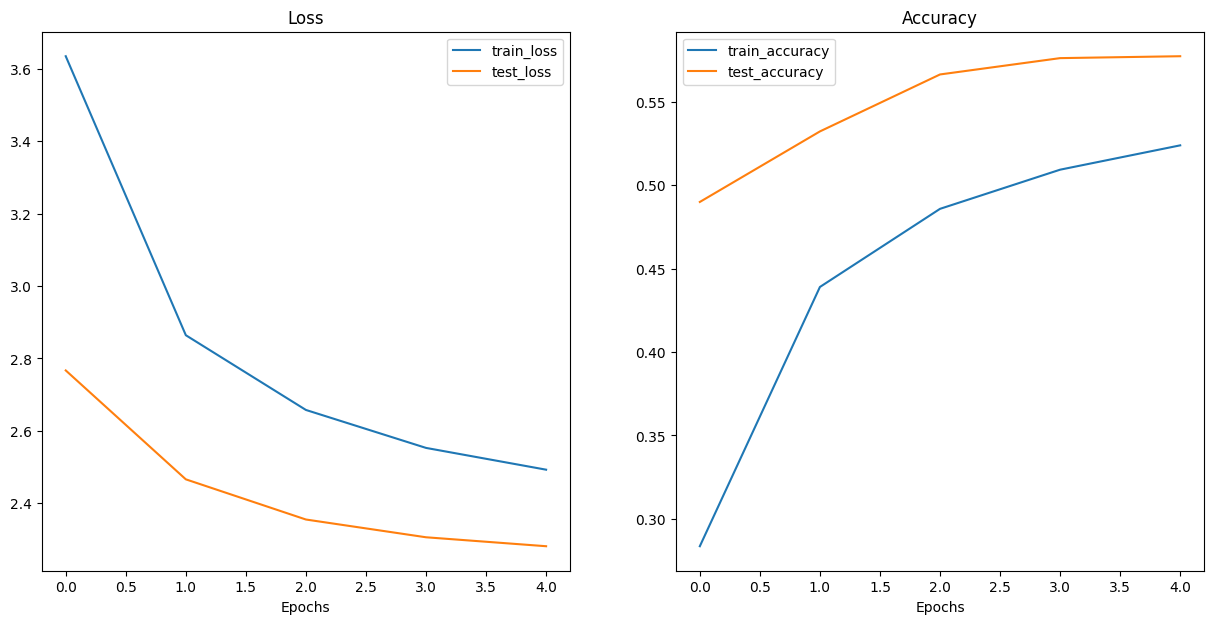

In [73]:
from helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb2_food101_results)

### 10.7 Saving and loading FoodVision Big

In [74]:
from going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth" 

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models\09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [75]:
# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

<All keys matched successfully>

### 10.8 Checking FoodVision Big model size

In [76]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


|   **Model**   |   **Output shape (num classes)**  |   **Trainable parameters**    |   **Total parameters**    | **Model size (MB)** |
|---------------|-----------------------------------|-------------------------------|---------------------------|---------------------|
|   FoodVision Mini (EffNetB2 feature extractor)| 3 | 4,227	  | 7,705,221 | 29 |
|   FoodVision Big (EffNetB2 feature extractor) |101| 142,309 |	7,843,303 | 30 |

### 11. Turning our FoodVision Big model into a deployable app
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt

In [77]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

### 11.1 Downloading an example image and moving it to the examples directory
For our example image, we're going to use the `pizza-dad` image (a photo of my dad eating pizza).

So let's download it from the course GitHub via the `!wget` command and then we can move it to `demos/foodvision_big/examples` with the `!mv` command (short for "move").

While we're here we'll move our trained Food101 EffNetB2 model from `models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth` to `demos/foodvision_big` as well.

In [79]:
# # Download and move an example image
# !wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg 
# !mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg

# # Move trained model to FoodVision Big demo folder (will error if model is already moved)
# !mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

### 11.2 Saving Food101 class names to file (class_names.txt)
Because there are so many classes in the Food101 dataset, instead of storing them as a list in our` app.py` file, let's saved them to a `.txt` file and read them in when necessary instead.

In [80]:
# Check out the first 10 Food101 class names
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

we can write these to a text file by first creating a path to` demos/foodvision_big/class_names.txt` and then opening a file with Python's `open()` and then writing to it leaving a new line for each class.

In [81]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
    f.write("\n".join(food101_class_names)) # leave a new line between each class

[INFO] Saving Food101 class names to demos\foodvision_big\class_names.txt


In [82]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in  f.readlines()]
    
# View the first 5 class names loaded back in
food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

### 11.3 Turning FoodVision Big model into a Python script (`model.py`)

In [83]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Writing demos/foodvision_big/model.py


### 11.4 Turning FoodVision Big Gradio app into a Python script (`app.py`)

In [84]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [food_name.strip() for food_name in  f.readlines()]
    
### 2. Model and transforms preparation ###    

# Create model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=101, # could also use len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface 
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Writing demos/foodvision_big/app.py


### 11.5 Creating a requirements file for FoodVision Big (`requirements.txt`)

In [86]:
%%writefile demos/foodvision_big/requirements.txt
torch==2.0.1+cu117
torchvision==0.15.2+cu117
gradio==3.48.0


Overwriting demos/foodvision_big/requirements.txt


### 11.6 Deploying our FoodVision Big app to HuggingFace Spaces

In [ ]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
# IFrame(src="https://huggingface.co/spaces/kushagra-909/Food-Vision-Big", width=900, height=750)